# Utils

In [3]:
def save_reviews(file, df_review, path='data'):
    f = f'{path}/{file}'
    df_review.to_csv(f, index=False)
    print(f'{f} saved.')


def load_reviews(file, path='data'):
    f = f'{path}/{file}'
    df = pd.read_csv(f, parse_dates=['date'])
    print(f'{f} loaded.')
    return df

# Scraping

In [4]:
from vivino_community_reviews import vivino_reviews, concat_reviews

import pandas as pd

In [2]:
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_more,
    'loc2': locator_recent, 
    'loc3': locator_review,
    'loc4': locator_date
}

In [3]:
kwargs.update({
    'end_date': '20220101',
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4,
})

In [4]:
wines = list()
wines.append([
    'Casillero del Diablo Cabernet Sauvignon (Reserva)',
    'https://www.vivino.com/casillero-del-diablo-cabernet-sauvignon-reserva-central-valley/w/1135067?ref=nav-search#all_reviews'
])
wines.append([
    'Yellow Tail Cabernet Sauvignon',
    'https://www.vivino.com/yellow-tail-cabernet-sauvignon/w/2549?ref=nav-search#all_reviews'
])

id_start = 0

In [4]:
wines = list()
wines.append([
    'Casillero del Diablo Chardonnay (Reserva)',
    'https://www.vivino.com/casillero-del-diablo-chardonnay-reserva/w/1135140?ref=nav-search#all_reviews'
])

id_start = 6

**load existing reviews**

In [8]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

In [5]:
col_rev = ['id', 'wine', 'date', 'review']

for wine_name, wine_url in wines:
    df = vivino_reviews(wine_url, wine_name, **kwargs)
    df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, save=True, id_start=id_start)

123it [01:54,  1.08it/s]

123 reviews collected.


**temp saving before translation**

In [ ]:
file = 'wine_reviews.csv'
path = 'data'

f = f'{path}/{file}'
df_review.to_csv(f, index=False)

# Review data

In [2]:
file = 'wine_reviews.csv'
path = 'data'

f = f'{path}/{file}'
df_reviews = pd.read_csv(f, parse_dates=['date'])

In [3]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,id,wine,date,review
120,6,Casillero del Diablo Chardonnay (Reserva),NaT,NaN


In [4]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [5]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     5
2023    47
2022    67
2021     3
Name: count, dtype: int64

<Axes: >

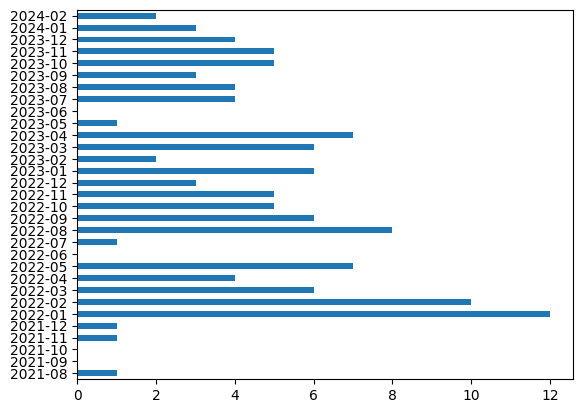

In [6]:
d = df_reviews.date.agg(['min', 'max']).to_list()
date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

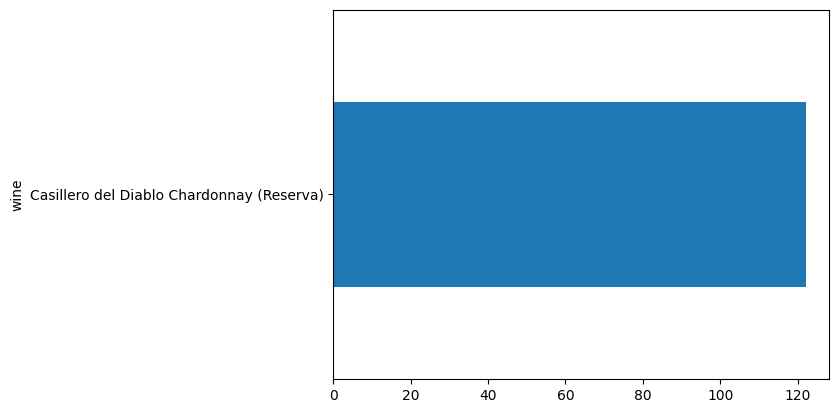

In [7]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [8]:
df_reviews.head()

,id,wine,date,review
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛"
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and..."
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio


# Translate

In [107]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [108]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append(
        {'id': rec['id'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])}
    )

100%|█████████████████████████████████████████████████████████████| 122/122 [01:05<00:00,  1.85it/s]


In [117]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,id_x,wine,date,review,id_y,lang,review_transl
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",6,ko,"Purchased cu 1.6, tastes like sauvignon blanc"
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...,6,pt,Chardonnay from the ubiquitous Concha y Toro. ...
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...,6,pt,Peach aroma very present!! Pairs well with sea...
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and...",6,en,"It's a pretty rough Chardonnay, unbalanced and..."
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio,6,en,Good cost-benefit


In [118]:
df_reviews.loc[df_reviews.lang=='ko']

,id_x,wine,date,review,id_y,lang,review_transl
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",6,ko,"Purchased cu 1.6, tastes like sauvignon blanc"
9,6,Casillero del Diablo Chardonnay (Reserva),2023-11-24,샤도네이같지 않은 시큼함..ㅠ,6,ko,"Sour, not like Chardonnay..ㅠ"
21,6,Casillero del Diablo Chardonnay (Reserva),2023-09-05,구란구스또,6,ko,Gurangusto
37,6,Casillero del Diablo Chardonnay (Reserva),2023-04-01,디아블로 쇼비뇽블랑이랑 비교해서먹음 쿰쿰한향이 덜하고 산도가 더 좋았던,6,ko,"Compared to Diablo Sauvignon Blanc, it had les..."
98,6,Casillero del Diablo Chardonnay (Reserva),2022-02-25,쇼블을 좋아하는 사람이라면...,6,ko,If you like shovel...


# Save

In [119]:
f = 'data/wine_reviews_transl2.csv'
df_reviews_base = pd.read_csv(f, parse_dates=['date'])

In [120]:
df_reviews_base

,id,wid,wine,date,review,lang,review_transl,review_len
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me,41
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...,62
2,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money,35
3,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...,77
4,5,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,"Muito bom, combina muito bem com carnes vermel...",pt,"Very good, goes very well with red meat and pa...",52
...,...,...,...,...,...,...,...,...
155,172,1,Yellow Tail Cabernet Sauvignon,2023-01-23,"Aromático, con sabor a vainilla. Carácter inco...",es,"Aromatic, with vanilla flavor. Unmistakable ch...",95
156,173,1,Yellow Tail Cabernet Sauvignon,2023-01-22,oak vanilla plum blackberry,sv,oak vanilla plum blackberry,27
157,174,1,Yellow Tail Cabernet Sauvignon,2023-01-02,Um vinho elegante e justo! Uma boa potência al...,pt,An elegant and fair wine! A good alcoholic str...,284
158,175,1,Yellow Tail Cabernet Sauvignon,2023-01-02,Easily drinkable and reliably inexpensive.,en,Easily drinkable and reliably inexpensive.,42


# Merge

In [14]:
import pandas as pd

file = 'wine_reviews_240124.csv'
path = 'data'

df_reviews_base = pd.read_csv(f'{path}/{file}',  parse_dates=['date'])

In [15]:
df_reviews_base.head()

,id,wid,wine,date,review,source,lang,review_transl
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,vivino,en,Little too cherry on the front end for me
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",vivino,no,A small sharp crack in the taste. Ok Friday wi...
2,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,vivino,ko,Good taste and good value for money
3,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,vivino,en,oak cherry black cherry chocolate blackcurrant...
4,5,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,"Muito bom, combina muito bem com carnes vermel...",vivino,pt,"Very good, goes very well with red meat and pa..."


In [3]:
df_reviews_base.date.max()

Timestamp('2024-01-24 00:00:00')

In [7]:
df_reviews_base['source'] = 'vivino'

In [8]:
df_reviews_base.head()

,id,wid,wine,date,review,lang,review_transl,review_len,source
0,0,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me,en,Little too cherry on the front end for me,41,vivino
1,1,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,m...",no,A small sharp crack in the taste. Ok Friday wi...,62,vivino
2,3,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯,ko,Good taste and good value for money,35,vivino
3,4,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant...,en,oak cherry black cherry chocolate blackcurrant...,77,vivino
4,5,0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,"Muito bom, combina muito bem com carnes vermel...",pt,"Very good, goes very well with red meat and pa...",52,vivino


In [11]:
df_reviews_base = df_reviews_base[['id', 'wid', 'wine', 'date', 'review', 'source', 'lang', 'review_transl']]

In [13]:
file = 'wine_reviews_240124.csv'
path = 'data'

df_reviews_base.to_csv(f'{path}/{file}', index=False)

In [ ]:
path = 'sample_data'
file = 'wine_reviews_cab6_transl'

df_reviews.to_csv(f'{path}/{file}.csv', index = False)

In [60]:
!zip -j {file}.zip {path}/{file}.csv

In [216]:
!zip wine_reviews.zip wine*csv

  adding: wine_0.csv (deflated 67%)
  adding: wine_1.csv (deflated 57%)


In [20]:
import os

path = 'data//'
wine_id = 0

if path is not None:
    f = f'{path}/wine_{wine_id}.csv'
    
os.path.exists(f)

True

In [21]:
f

'data///wine_0.csv'

In [24]:
!cat data////wine_0.csv

id,wine,date,review
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-24,Little too cherry on the front end for me
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-20,"En liten skarp knekk i smaken. Ok fredagsvin,men ikke no mer."
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-19,Aight
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-18,무난한 맛 가성비 좋은듯
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,oak cherry black cherry chocolate blackcurrant plum vanilla blackberry pepper
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-17,"Muito bom, combina muito bem com carnes vermelhas e massa..."
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-16,Så jävla sött
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-16,Enjoyed this bottle.
0,Casillero del Diablo Cabernet Sauvignon (Reserva),2024-01-12,"Ready to drink, fresh, zingy Cab Sauv. Red fruit on the nose with some vanilla. Medium to heavy in body with n